<a href="https://colab.research.google.com/github/dsnato/desafio_lh_cd/blob/main/LH_CD_RENATOSAMICO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Análise e Modelagem Preditiva de Notas IMDB
**Objetivo:** prever `IMDB_Rating` a partir de informações de filmes, aplicando boas práticas de EDA, engenharia de atributos, prevenção de *data leakage* e avaliação robusta.

**Riscos monitorados:**
- *Data leakage*: evitar variáveis que “entregam” o alvo (ex.: `Meta_score`) ou encodings que usam o próprio `IMDB_Rating` diretamente.  
- *Overfitting*: monitorar curvas de aprendizado e comparar com modelos baseline.  
- *Multicolinearidade*: identificar e mitigar pares de *features* com correlação linear muito alta (Pearson).


In [2]:
# Importações e configurações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

import xgboost as xgb

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)

## 2) Carregamento dos dados e visão geral
Nesta etapa, carregamos o dataset, verificamos *missing values* e tipos das colunas.  
Esse passo garante que os próximos gráficos e transformações partam de um estado consistente.


In [3]:
# Carregamento
df = pd.read_csv("desafio_indicium_imdb.csv")

# Visão geral
display(df.head())
display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(10))

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


None

,0
Gross,169
Meta_score,157
Certificate,101
Unnamed: 0,0
Runtime,0
Genre,0
Series_Title,0
Released_Year,0
Overview,0
IMDB_Rating,0


## 3) EDA (Exploratory Data Analysis)
Vamos inspecionar distribuições, relações e correlações:
- Distribuições de `IMDB_Rating` e `Meta_score`.
- Relação visual entre `Meta_score` e `IMDB_Rating` (scatter).
- **Correlação de Pearson** entre as variáveis numéricas (matriz + valor direto entre `Meta_score` e `IMDB_Rating`).
- Top gêneros (contagem).


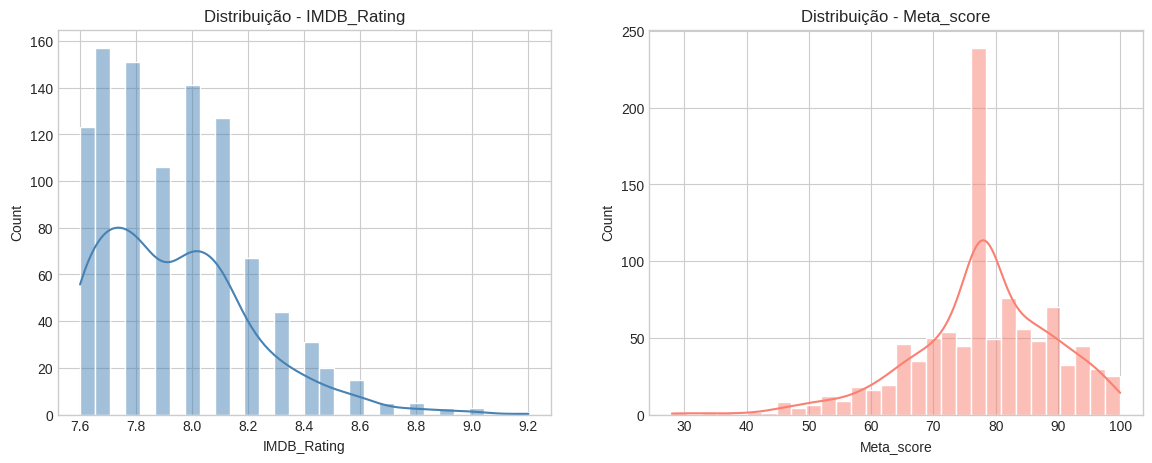

In [4]:
# Conversões preliminares para EDA
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())
df['Runtime'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False)
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')


plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['IMDB_Rating'], bins=30, kde=True, color='steelblue')
plt.title('Distribuição - IMDB_Rating')

plt.subplot(1,2,2)
sns.histplot(df['Meta_score'], bins=30, kde=True, color='salmon')
plt.title('Distribuição - Meta_score')

plt.show()

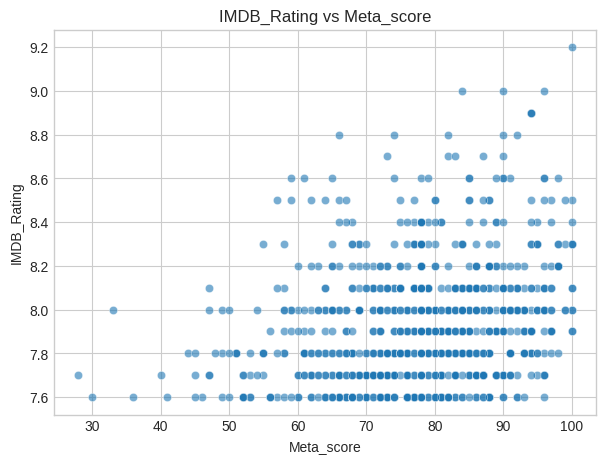

In [5]:
# Scatter IMDB vs Meta
plt.figure(figsize=(7,5))
sns.scatterplot(x='Meta_score', y='IMDB_Rating', data=df, alpha=0.6)
plt.title('IMDB_Rating vs Meta_score')
plt.show()

In [6]:
# Correlação de Pearson (IMDB vs Meta_score)
pearson_imdb_meta = df['IMDB_Rating'].corr(df['Meta_score'], method='pearson')
print(f"Correlação de Pearson (IMDB_Rating, Meta_score): {pearson_imdb_meta:.3f}")

Correlação de Pearson (IMDB_Rating, Meta_score): 0.256


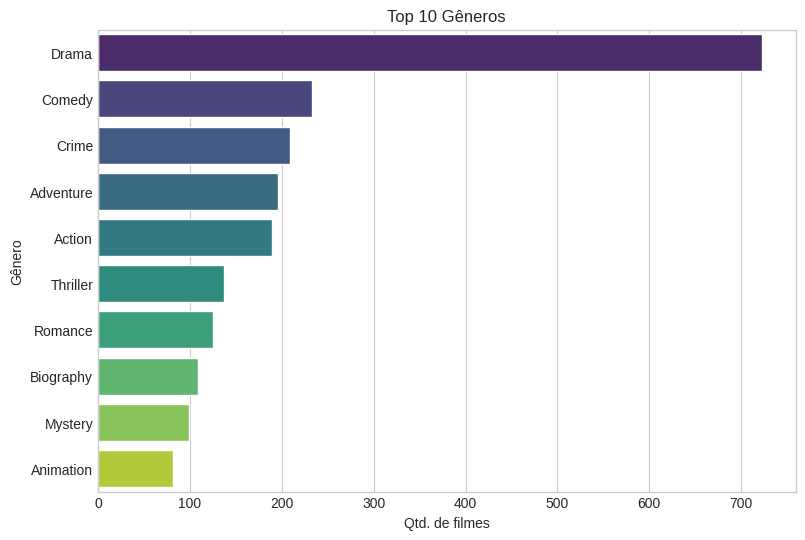

In [7]:
# Top gêneros
plt.figure(figsize=(9,6))
all_genres = df['Genre'].astype(str).str.split(', ').explode().reset_index(drop=True)
sns.countplot(y=all_genres, order=all_genres.value_counts().index[:10], palette='viridis')
plt.title('Top 10 Gêneros')
plt.xlabel('Qtd. de filmes')
plt.ylabel('Gênero')
plt.show()

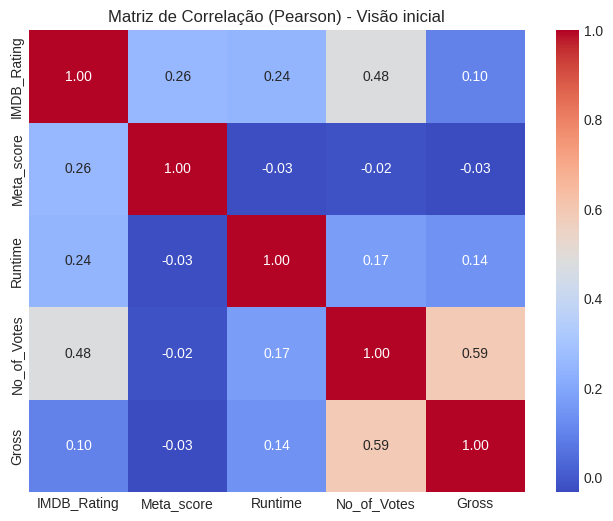

In [9]:
# Matriz de correlação de Pearson (numéricas principais)
num_cols_pre = ['IMDB_Rating','Meta_score','Runtime','No_of_Votes','Gross']
num_df_pre = df[num_cols_pre].copy()
num_df_pre['No_of_Votes'] = pd.to_numeric(num_df_pre['No_of_Votes'], errors='coerce')
num_df_pre['Gross'] = pd.to_numeric(num_df_pre['Gross'].astype(str).str.replace(',','', regex=False), errors='coerce')

plt.figure(figsize=(8,6))
sns.heatmap(num_df_pre.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação (Pearson) - Visão inicial')
plt.show()

**Interpretação crítica:**  
- Se a correlação `IMDB_Rating` × `Meta_score` estiver muito alta (ex.: > 0.8), usar `Meta_score` como *feature* tende a produzir um modelo artificialmente bom (**leakage**).  
- A distribuição de `IMDB_Rating` costuma ser concentrada em ~7–8; baixa variância no alvo exige *features* informativas.  
- Gêneros múltiplos por filme reforçam a necessidade de **one-hot encoding**.


## 4) Feature Engineering seguro
Implementaremos:
1. **One-hot encoding** de gêneros.  
2. **Bins de reputação** (quartis) para diretor e ator principal (**sem usar o valor exato do alvo**, reduzindo vazamento).  
3. **Média de rating entre os 3 atores principais** (Star1–Star3), mascarada via média histórica agregada.  
4. **Transformações log** em `Gross` e `No_of_Votes` para reduzir assimetria.

> Em cada sub-etapa, traremos **validações visuais** para garantir que as transformações fazem sentido.

In [10]:
# One-hot de gêneros
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
genres_list = list(pd.Series([g for lst in df['Genre'] for g in lst]).dropna().unique())
for g in genres_list:
    df[f'Genre_{g}'] = df['Genre'].apply(lambda x: 1 if g in x else 0)

In [12]:
# Reputação (bins) para diretor e ator principal
# médias históricas por pessoa
director_mean = df.groupby('Director')['IMDB_Rating'].mean()
star1_mean = df.groupby('Star1')['IMDB_Rating'].mean()

In [14]:
# Mapear e tratar NaNs com a média global (evita erro no qcut)
global_mean = df['IMDB_Rating'].mean()
dir_rep = df['Director'].map(director_mean).fillna(global_mean)
star1_rep = df['Star1'].map(star1_mean).fillna(global_mean)

In [15]:
# qcut com quartis; duplicates='drop' evita erro quando há empates nos quantis
df['Director_Bin'] = pd.qcut(dir_rep, q=4, labels=['baixo','médio-baixo','médio-alto','alto'], duplicates='drop')
df['Star1_Bin'] = pd.qcut(star1_rep, q=4, labels=['baixo','médio-baixo','médio-alto','alto'], duplicates='drop')

In [17]:
# Média de rating entre Star1-Star3 (máscara agregada)
for col in ['Star1','Star2','Star3']:
    df[col+'_rating'] = df.groupby(col)['IMDB_Rating'].transform('mean')

df['Actors_Mean_Rating'] = df[['Star1_rating','Star2_rating','Star3_rating']].mean(axis=1, skipna=True)
df['Actors_Mean_Rating'] = df['Actors_Mean_Rating'].fillna(global_mean)

In [18]:
# Transformações log
df['Gross'] = pd.to_numeric(df['Gross'].astype(str).str.replace(',', '', regex=False), errors='coerce')
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')

df['Gross_log'] = np.log1p(df['Gross'])
df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])

In [19]:
# One-hot dos bins
df = pd.get_dummies(df, columns=['Director_Bin','Star1_Bin'])

### 4.1) Validação visual – One-hot de gêneros
- Quantas colunas de gênero foram criadas?
- Frequência de filmes por gênero (após one-hot).

Número de colunas de gênero (one-hot): 21


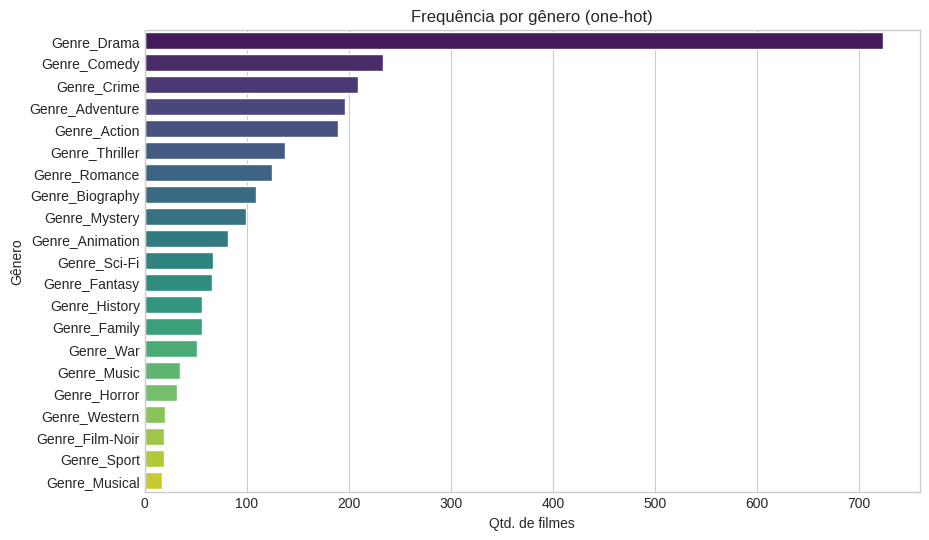

In [20]:
genre_cols = [c for c in df.columns if c.startswith('Genre_')]
print(f"Número de colunas de gênero (one-hot): {len(genre_cols)}")

genre_counts = df[genre_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Frequência por gênero (one-hot)')
plt.xlabel('Qtd. de filmes')
plt.ylabel('Gênero')
plt.show()

### 4.2) Validação visual – Bins de reputação (Diretor e Ator principal)
Confirmar se os quartis estão razoavelmente balanceados aumenta nossa confiança na discretização.

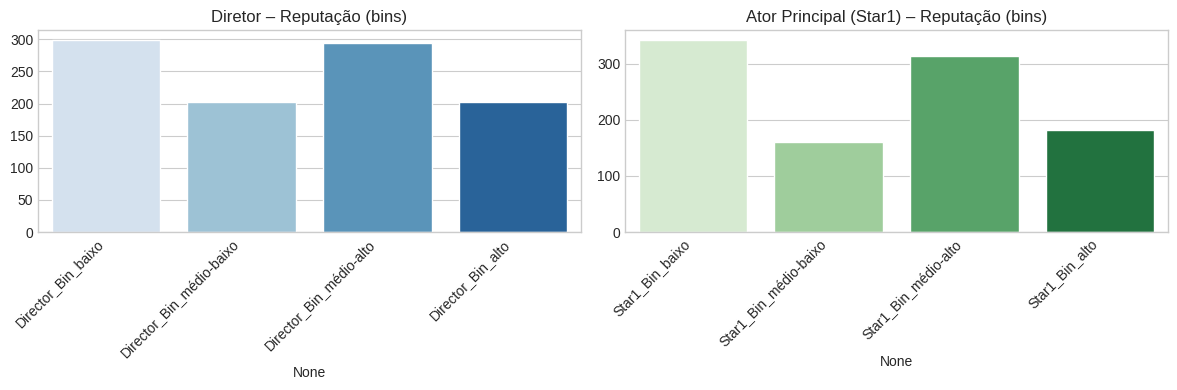

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
director_bin_cols = [col for col in df.columns if col.startswith('Director_Bin_')]
director_bin_counts = df[director_bin_cols].sum()
sns.barplot(x=director_bin_counts.index, y=director_bin_counts.values, palette='Blues')
plt.title('Diretor – Reputação (bins)')
plt.xticks(rotation=45, ha='right') # Gira os rótulos para melhor legibilidade

plt.subplot(1,2,2)
star1_bin_cols = [col for col in df.columns if col.startswith('Star1_Bin_')]
star1_bin_counts = df[star1_bin_cols].sum()
sns.barplot(x=star1_bin_counts.index, y=star1_bin_counts.values, palette='Greens')
plt.title('Ator Principal (Star1) – Reputação (bins)')
plt.xticks(rotation=45, ha='right') # Gira os rótulos para melhor legibilidade

plt.tight_layout()
plt.show()

### 4.3) Validação visual – Distribuição de `Actors_Mean_Rating`
Essa *feature* agrega a “força média” do elenco principal; avaliamos forma e outliers.

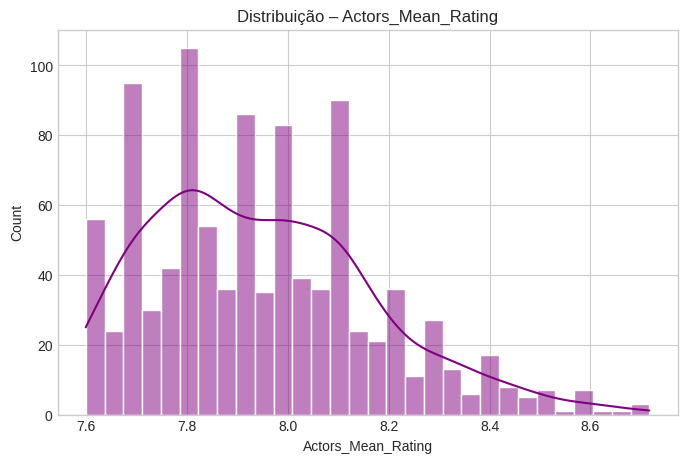

,Actors_Mean_Rating
count,999.000000
mean,7.947948
std,0.224076
min,7.600000
25%,7.788889
50%,7.916667
75%,8.100000
max,8.716667


In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['Actors_Mean_Rating'], bins=30, kde=True, color='purple')
plt.title('Distribuição – Actors_Mean_Rating')
plt.show()
display(df['Actors_Mean_Rating'].describe())

### 4.4) Validação visual – Transformações log (`Gross` e `No_of_Votes`)
Visualmente, a distribuição deve se tornar menos assimétrica após a transformação logarítmica (comparação side-by-side: original vs log).

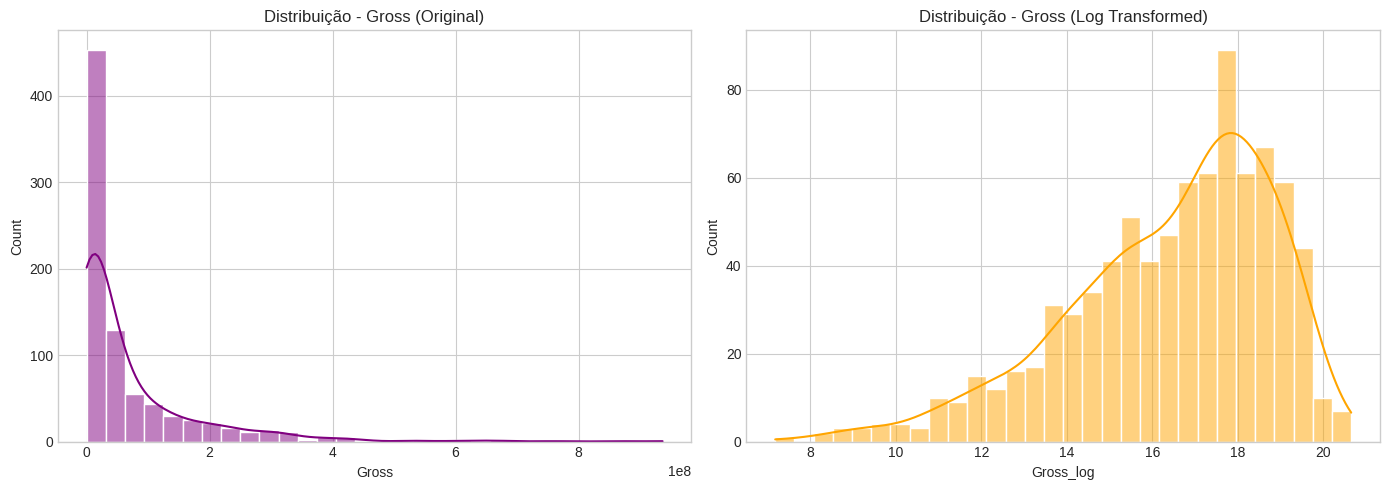

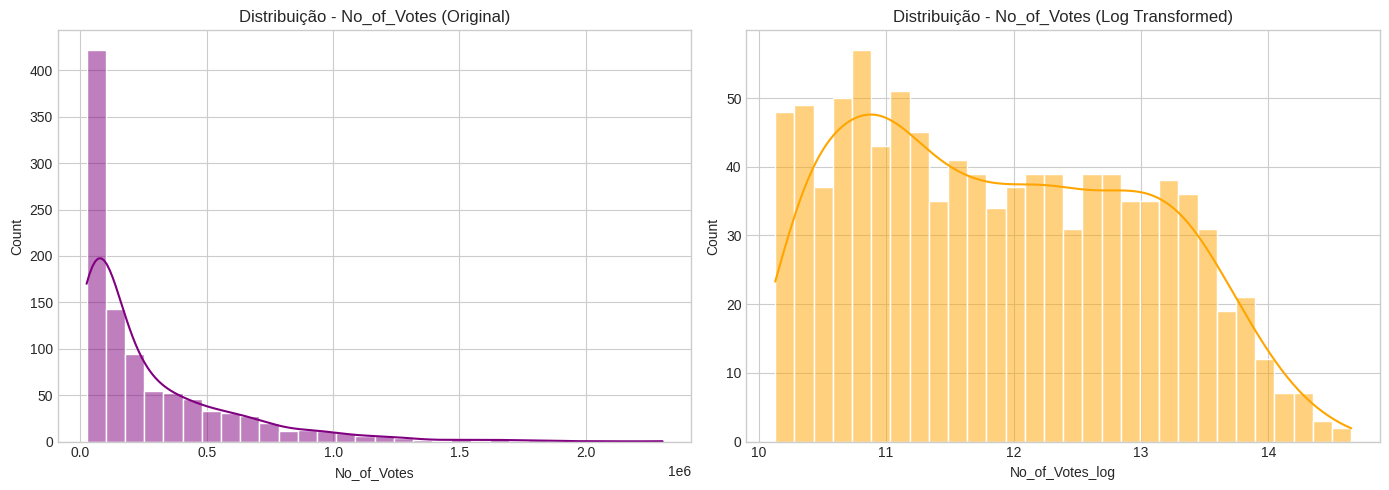

In [23]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df['Gross'].dropna(), bins=30, kde=True, color='purple')
plt.title('Distribuição - Gross (Original)')

plt.subplot(1,2,2)
sns.histplot(df['Gross_log'].dropna(), bins=30, kde=True, color='orange')
plt.title('Distribuição - Gross (Log Transformed)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df['No_of_Votes'].dropna(), bins=30, kde=True, color='purple')
plt.title('Distribuição - No_of_Votes (Original)')

plt.subplot(1,2,2)
sns.histplot(df['No_of_Votes_log'].dropna(), bins=30, kde=True, color='orange')
plt.title('Distribuição - No_of_Votes (Log Transformed)')

plt.tight_layout()
plt.show()

## 5) Seleção de *features* e checagens de correlação
- Definiremos o conjunto de *features* **sem usar `Meta_score`** (forte risco de *leakage*).  
- Calcularemos **matriz de correlação de Pearson** e listaremos pares com |r| > 0.85.  
- Opcionalmente removeremos automaticamente colunas redundantes (mantendo a primeira ocorrência).

In [27]:
# Conjunto de features seguras
base_features = [
    'Runtime','No_of_Votes_log','Gross_log','Actors_Mean_Rating'
] + genre_cols + [c for c in df.columns if c.startswith('Director_Bin_') or c.startswith('Star1_Bin_')]

target = 'IMDB_Rating'
X_all = df[base_features].copy()
y_all = df[target].copy()

In [28]:
# Matriz de correlação das features
corr_feat = X_all.corr(method='pearson').abs()

Pares com |correlação| > 0.85:


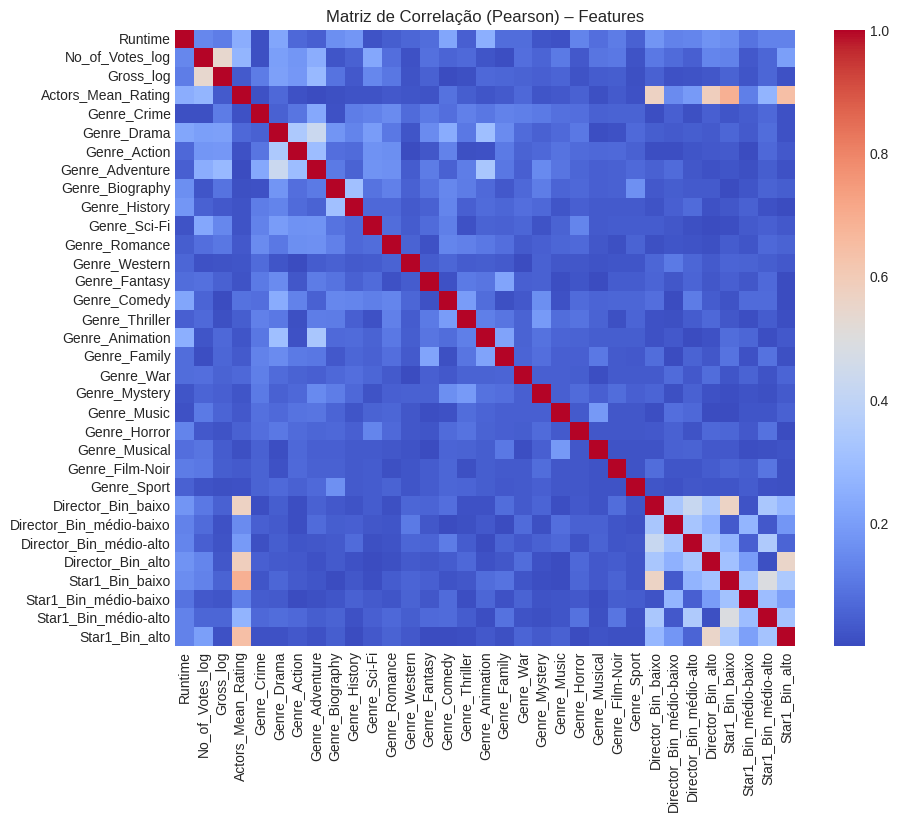

In [30]:
# Listagem de pares com alta correlação
threshold = 0.85
high_pairs = []
cols = corr_feat.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr_feat.iloc[i, j]
        if r > threshold:
            high_pairs.append((cols[i], cols[j], r))

print("Pares com |correlação| > 0.85:")
for a,b,r in sorted(high_pairs, key=lambda x: -x[2])[:20]:
    print(f"{a}  ~  {b}  ->  r={r:.3f}")

plt.figure(figsize=(10,8))
sns.heatmap(corr_feat, cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação (Pearson) – Features')
plt.show()

In [31]:
# Função para remover colunas altamente correlacionadas (mantém a primeira)
def drop_high_corr(df_features, thr=0.85):
    corr = df_features.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thr)]
    return df_features.drop(columns=to_drop), to_drop

X_filt, dropped_corr_cols = drop_high_corr(X_all, thr=threshold)
print(f"Colunas removidas por alta correlação (thr={threshold}): {dropped_corr_cols}")

Colunas removidas por alta correlação (thr=0.85): []


**Nota:** a filtragem por correlação é conservadora e pode remover redundâncias.  
Modelos como XGBoost lidam melhor com colinearidade, mas **evitar redundância** costuma ajudar modelos lineares e simplifica interpretação.

## 6) Pré-processamento final para Modelagem

Nesta etapa, finalizamos a preparação dos dados antes de treinar os modelos:

1.  **Tratamento de Missing Values:** Abordaremos os valores ausentes remanescentes.
2.  **Seleção de Features:** Definiremos as features (X) e o alvo (y) para o modelo.
3.  **Divisão Treino/Teste:** Separaremos os dados em conjuntos de treino e teste para avaliação justa.
4.  **Escalamento de Features:** Aplicaremos escalamento às features numéricas para otimizar a performance de alguns modelos.

In [24]:
# Verificar se há valores faltantes restantes
print("Missing values before final preprocessing:")
display(df.isnull().sum().sort_values(ascending=False).head())

# Lidar com os valores faltantes restantes, se houver (por exemplo, preencher com mediana para numérico)
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        elif df[col].dtype == 'object':
             df[col].fillna(df[col].mode()[0], inplace=True) # Exemplo para tipo de objeto

print("\nMissing values after final preprocessing:")
display(df.isnull().sum().sort_values(ascending=False).head())

# Definir características (X) e alvo (y)
# Remover colunas originais que foram transformadas ou não são necessárias para a modelagem
columns_to_drop = ['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'Overview',
                   'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Gross', 'No_of_Votes',
                   'Star1_rating', 'Star2_rating', 'Star3_rating'] # Adicionar outras colunas originais se necessário

# Garantir que apenas colunas existentes sejam descartadas
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop + ['IMDB_Rating'])
y = df['IMDB_Rating']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData split into training and testing sets:")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Missing values before final preprocessing:


,0
Gross,169
Gross_log,169
Certificate,101
Released_Year,0
Series_Title,0



Missing values after final preprocessing:


,0
Unnamed: 0,0
Series_Title,0
Released_Year,0
Certificate,0
Runtime,0



Data split into training and testing sets:
Shape of X_train: (799, 34)
Shape of X_test: (200, 34)
Shape of y_train: (799,)
Shape of y_test: (200,)


## 6) *Train/Test split* e modelos baseline
Treinaremos:
- **Regressão Linear** (*baseline* simples)
- **Random Forest** (*baseline* mais robusto)

Métrica: **RMSE** (quanto menor, melhor).

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_all, test_size=0.2, random_state=42
)

def avaliar_modelo(model, nome):
    model_ = clone(model)
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{nome} | RMSE: {rmse:.4f}")
    return model_, rmse, pred

lr_model, rmse_lr, pred_lr = avaliar_modelo(LinearRegression(), "Regressão Linear")
rf_model, rmse_rf, pred_rf = avaliar_modelo(RandomForestRegressor(
    n_estimators=400, random_state=42, n_jobs=-1
), "Random Forest")

Regressão Linear | RMSE: 0.0722
Random Forest | RMSE: 0.0672


## 7) Treinamento e Avaliação de Modelos

Nesta etapa, treinaremos diferentes modelos de regressão nos dados de treino e avaliaremos sua performance nos dados de teste. Usaremos o Root Mean Squared Error (RMSE) como métrica de avaliação.

Compararemos os seguintes modelos:
-   Linear Regression
-   Random Forest Regressor
-   XGBoost Regressor

XGBoost | RMSE: 0.0682


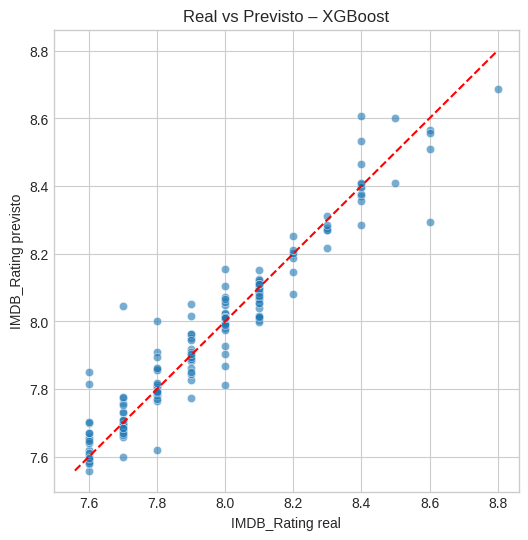

In [33]:
xgb_params = dict(
    objective='reg:squarederror',
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model, rmse_xgb, pred_xgb = avaliar_modelo(xgb_model, "XGBoost")

# Real vs Previsto
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_xgb, alpha=0.6)
lim_min = min(y_test.min(), pred_xgb.min())
lim_max = max(y_test.max(), pred_xgb.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], '--r')
plt.title('Real vs Previsto – XGBoost')
plt.xlabel('IMDB_Rating real')
plt.ylabel('IMDB_Rating previsto')
plt.show()

In [34]:
# Função para treinar e avaliar um modelo
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """Trains a model and evaluates its performance using RMSE."""
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Inicializar modelos
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Treinar e avaliar modelos
rmse_lr = train_and_evaluate(lr_model, X_train, y_train, X_test, y_test)
rmse_rf = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)
rmse_xgb = train_and_evaluate(xgb_model, X_train, y_train, X_test, y_test)

# Imprimir resultados
print(f"RMSE - Linear Regression: {rmse_lr:.4f}")
print(f"RMSE - Random Forest: {rmse_rf:.4f}")
print(f"RMSE - XGBoost: {rmse_xgb:.4f}")

# Armazene os resultados em um dicionário para facilitar a comparação
results = {
    'Linear Regression': rmse_lr,
    'Random Forest': rmse_rf,
    'XGBoost': rmse_xgb
}

# Opcional: Exibir resultados como um DataFrame
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
results_df = results_df.sort_values(by='RMSE')
print("\nModel Performance (RMSE):")
display(results_df)

RMSE - Linear Regression: 0.0722
RMSE - Random Forest: 0.0680
RMSE - XGBoost: 0.0717

Model Performance (RMSE):


,Model,RMSE
1,Random Forest,0.067998
2,XGBoost,0.071665
0,Linear Regression,0.072226


### 7.1) Curvas de Aprendizado (XGBoost)
Curvas de aprendizado ajudam a identificar:
- **Overfitting**: erro de treino muito menor que o de validação.
- **Underfitting**: ambos os erros altos, mesmo com mais dados.

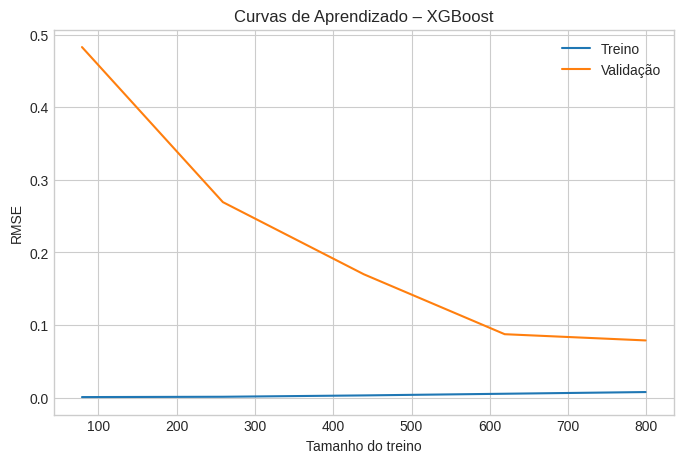

In [35]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb.XGBRegressor(**xgb_params),
    X=X_filt, y=y_all,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_rmse = -train_scores.mean(axis=1)
test_rmse = -test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, label='Treino')
plt.plot(train_sizes, test_rmse, label='Validação')
plt.xlabel('Tamanho do treino')
plt.ylabel('RMSE')
plt.title('Curvas de Aprendizado – XGBoost')
plt.legend()
plt.show()

## 8) Importância de *features* e **remoção da variável mais importante**
Para reduzir risco de dependência excessiva (e potencial *leakage*), identificamos a *feature* mais importante no XGBoost, **removemos** e **re-treinamos** o modelo para comparar o RMSE.


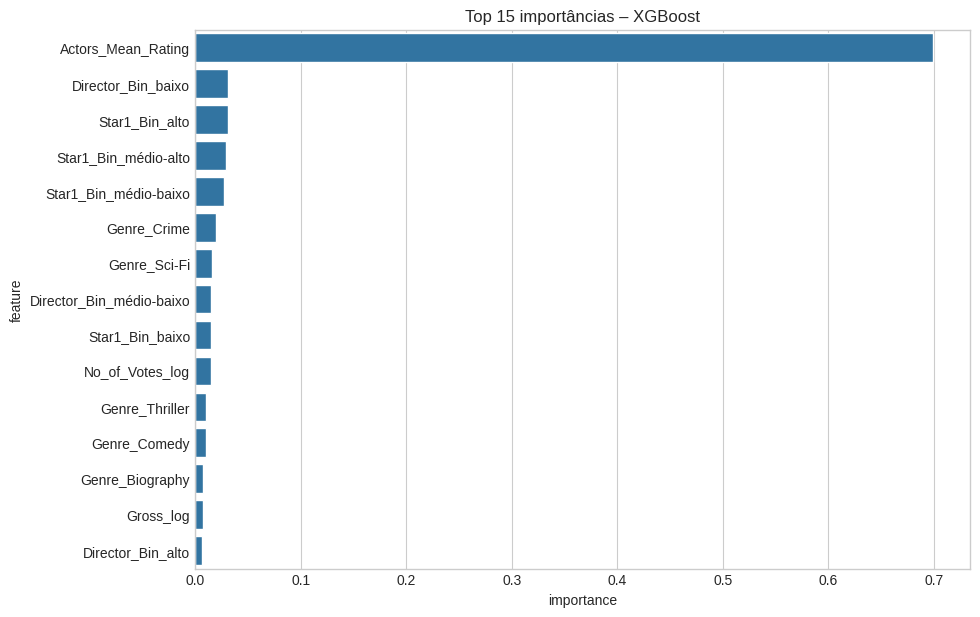

🔎 Variável mais importante identificada: Actors_Mean_Rating
XGBoost (original) RMSE: 0.0717
XGBoost (sem 'Actors_Mean_Rating') RMSE: 0.1469


In [36]:
# Importância de features
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x='importance', y='feature', data=importances.head(15))
plt.title('Top 15 importâncias – XGBoost')
plt.show()

top_feature = importances.iloc[0]['feature']
print(f"🔎 Variável mais importante identificada: {top_feature}")

# Remover a variável mais importante e re-treinar
X_filt_drop = X_filt.drop(columns=[top_feature])
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_filt_drop, y_all, test_size=0.2, random_state=42
)

xgb_model2 = xgb.XGBRegressor(**xgb_params)
xgb_model2.fit(X_train2, y_train2)
pred2 = xgb_model2.predict(X_test2)
rmse_xgb2 = np.sqrt(mean_squared_error(y_test2, pred2))

print(f"XGBoost (original) RMSE: {rmse_xgb:.4f}")
print(f"XGBoost (sem '{top_feature}') RMSE: {rmse_xgb2:.4f}")

**Leitura dos resultados:**  
- Se o RMSE não piorar muito (ou até melhorar) após remover a *feature* mais importante, ganhamos **robustez** contra *leakage* e **generalização**.  
- Caso haja grande piora, avaliamos se a *feature* removida era de fato utilizável em produção (ex.: métricas de crítica que só são conhecidas após lançamento não devem estar no treino).

## 9) Conclusões
- **Baselines** (Regressão Linear e Random Forest) oferecem referência clara; o ganho do XGBoost deve ser justificado.  
- **Reputação em bins** e **média dos 3 atores** são alternativas mais seguras que *target encoding* direto.  
- **Curvas de aprendizado** ajudam a guiar regularização e coleta de dados.  
- **Remoção da variável mais importante** reduz risco de dependência/vazamento e testa a resiliência do pipeline.  